# ARIMA-GARCH Assumption Checks

**Objective:** Verify assumptions needed for reliable ARIMA(p,d,q) modeling with a GARCH volatility component and produce diagnostic evidence for model selection.
- **Stationarity** - Checked with ADF (unit root) and KPSS (stationarity)
- **Linearity** - AR/MA are linear by design
- **No autocorrelation in residuals** - Checked with Ljung-Box test
- **Homoscedasticity** - Visual checks with residual plot
- **Invertibility**

**Workflow**:  
1. Simple feature cleaning/engineering
2. Stationarity Check 
3. PACF/ACF (p/q selection)
4. Residual Diagnosis
5. Finalization of ARIMA(p/d/q)-GARCH

## 1. Simple feature cleaning/engineering

In [2]:
import pandas as pd
import numpy as np

crypto = pd.read_csv("../data/raw_data/BTCUSDT_1h.csv")

# +--------------------------------------------------------------+
# |              PRELIMINARY FEATURE ENGINEERING                 |
# +--------------------------------------------------------------+

# checking if timestamp has any gaps/duplicates
crypto['timestamp'] = pd.to_datetime(crypto['timestamp'])
crypto = crypto.sort_values(by='timestamp').reset_index(drop=True)
crypto = crypto.drop_duplicates(subset=['timestamp']).reset_index(drop=True)

# log returns
crypto['log_return'] = np.log(crypto['close'] / crypto['close'].shift(1))
crypto = crypto.dropna(subset=['log_return']).reset_index(drop=True)

display(crypto)

,timestamp,open,high,low,close,volume,log_return
0,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,0.005454
1,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,0.003677
2,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,-0.002466
3,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,-0.001072
4,2020-01-01 05:00:00,7217.26,7229.76,7216.65,7224.21,344.670596,0.000961
...,...,...,...,...,...,...,...
43810,2024-12-31 19:00:00,93875.69,94290.91,93712.45,94166.88,462.793420,0.003097
43811,2024-12-31 20:00:00,94166.88,94222.50,93450.17,93564.04,733.041470,-0.006422
43812,2024-12-31 21:00:00,93564.01,93964.15,93504.67,93899.68,337.527150,0.003581
43813,2024-12-31 22:00:00,93899.67,93899.67,93375.58,93488.84,315.532720,-0.004385


## 2. Stationarity Check

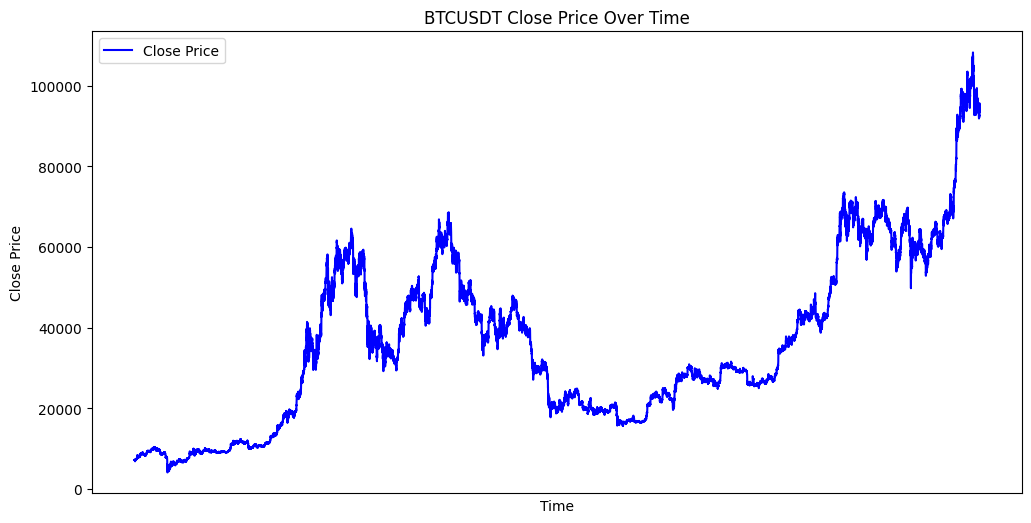

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(crypto['timestamp'], crypto['close'], label='Close Price', color='blue')
plt.title('BTCUSDT Close Price Over Time')
plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings("ignore")

# ADF test for unit root
print("Augmented Dickey-Fuller Test:")
print("H0: The series has a unit root (non-stationary)")
print("H1: The series is stationary")
print("-" * 50)

adf_result = adfuller(crypto['log_return'])     # * Actual test is done here XDD
print("ADF Statistic:", adf_result[0])
print("-" * 50)

if adf_result[1] < 0.05:
    print(f"The series is stationary with p-value {adf_result[1]} (reject H0)\n")
else:
    print(f"The series is non-stationary with p-value {adf_result[1]} (fail to reject H0)\n")


# KPSS test for stationarity
print("=" * 50 ,"\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
print("H0: The series is stationary")  
print("H1: The series has a unit root (non-stationary)")
print("-" * 50)

kpss_result = kpss(crypto['log_return'], regression='c', nlags="auto")  # * Actual test is done here XDD
print("KPSS Statistic:", kpss_result[0])  
print("-" * 50)

if kpss_result[1] < 0.05:
    print(f"The series is non-stationary with p-value {kpss_result[1]} (reject H0)")  
else:
    print(f"The series is stationary with p-value {kpss_result[1]} (fail to reject H0)")

Augmented Dickey-Fuller Test:
H0: The series has a unit root (non-stationary)
H1: The series is stationary
--------------------------------------------------
ADF Statistic: -29.090831548018254
--------------------------------------------------
The series is stationary with p-value 0.0 (reject H0)

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
H0: The series is stationary
H1: The series has a unit root (non-stationary)
--------------------------------------------------
KPSS Statistic: 0.17799457914727884
--------------------------------------------------
The series is stationary with p-value 0.1 (fail to reject H0)


## PACF/ACF diagnosis for p/q selection 

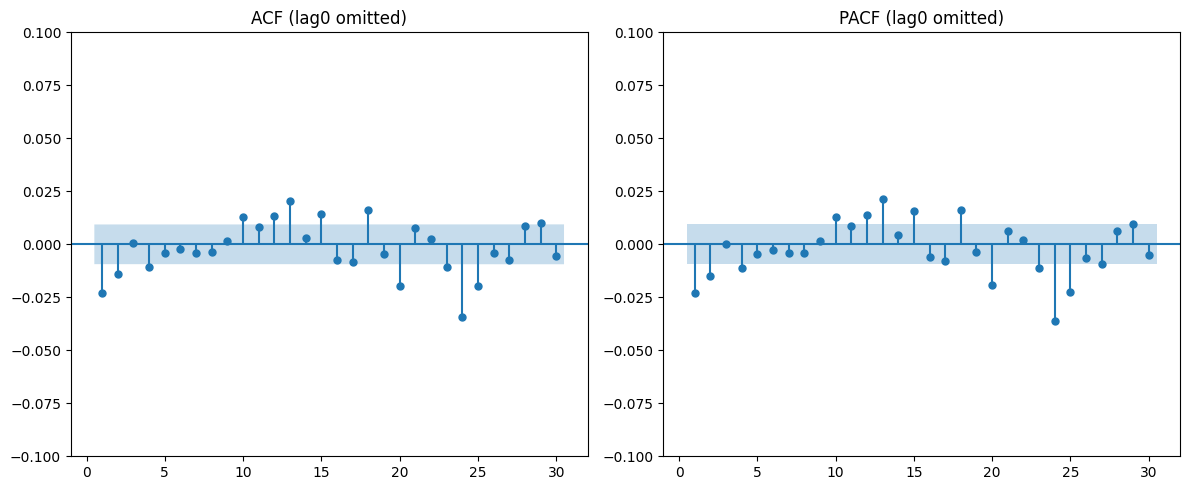

ACF (first 10): [ 1.00000000e+00 -2.31731507e-02 -1.42427777e-02  7.86466968e-04
 -1.08565737e-02 -4.14428647e-03 -2.34166851e-03 -3.95526038e-03
 -3.58625926e-03  1.78532952e-03  1.28075189e-02]
PACF (first 10): [ 1.00000000e+00 -2.31736796e-02 -1.47883890e-02  1.08947879e-04
 -1.10554999e-02 -4.65073138e-03 -2.87119005e-03 -4.20435381e-03
 -3.97783862e-03  1.39267772e-03  1.27100793e-02]

Ljung-Box test (lags 10,20):
       lb_stat     lb_pvalue
10   47.182020  8.749403e-07
20  119.990185  2.863467e-16


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Visual: omit lag-0 and zoom so small autocorrelations are visible
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(crypto['log_return'], lags=30, ax=plt.gca(), zero=False)
plt.ylim(-0.1, 0.1)   # adjust to taste
plt.title('ACF (lag0 omitted)')

plt.subplot(1,2,2)
plot_pacf(crypto['log_return'], lags=30, ax=plt.gca(), zero=False, method='ywm')
plt.ylim(-0.1, 0.1)
plt.title('PACF (lag0 omitted)')

plt.tight_layout()
plt.show()

# Numeric check + statistical test
print("ACF (first 10):", acf(crypto['log_return'].values, nlags=10, fft=True))
print("PACF (first 10):", pacf(crypto['log_return'].values, nlags=10))

print("\nLjung-Box test (lags 10,20):")
print(acorr_ljungbox(crypto['log_return'].values, lags=[10,20], return_df=True))